In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as gnn
import pickle
from tqdm import tqdm
import numpy as np
from torch.functional import F
import matplotlib.pyplot as plt


with open("data/train_graphs_data.pkl", "rb") as file:
    all_graphs = pickle.load(file)
    file.close()

In [140]:
len(all_graphs), all_graphs[0], all_graphs[0].y[0]

(90,
 Data(x=[1140, 33], edge_index=[2, 11709], edge_attr=[11709, 2], y=[1140, 2]),
 tensor([-0.2741, -0.6940]))

# 制作模型

### SAGE用于对图进行embedding

In [141]:
class SAGEModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SAGEModel, self).__init__()

        edge_dim = 8

        self.graph_features = nn.ModuleList(
            [
                gnn.GATv2Conv(input_size, 128, heads=2, edge_dim=edge_dim),
                nn.LayerNorm(128 * 2),
                nn.ReLU(),
                gnn.GATv2Conv(128 * 2, 128, heads=2, edge_dim=edge_dim),
                nn.LayerNorm(128 * 2),
                nn.ReLU(),
                gnn.SAGEConv(128 * 2, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
                gnn.SAGEConv(128, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
                # nn.Dropout(0.1),
            ]
        )

        # 考虑更多的trick，如layernorm等等
        self.regression = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, output_size),
        )

        self.edge_linear = nn.Sequential(
            nn.Linear(2, 16),
            nn.LayerNorm(16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.LayerNorm(16),
            nn.ReLU(),
            nn.Linear(16, edge_dim),
        )

    def forward(self, data):
        x, edge_index, edge_raw_attr = data.x, data.edge_index, data.edge_attr

        output = x

        edge_attr = self.edge_linear(edge_raw_attr)

        for layer in self.graph_features:
            if isinstance(layer, gnn.GATv2Conv):
                output = layer(output, edge_index, edge_attr)
            elif isinstance(layer, gnn.SAGEConv):
                output = layer(output, edge_index)
            else:
                output = layer(output)

        output = self.regression(output)

        return output

In [142]:
# 看看模型的输入输出
model = SAGEModel(input_size=33, output_size=64)
output = model(all_graphs[0])
output.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1140x256 and 33x256)

### LSTM用于串联每个节点的embedding，并计算回归值

输入：x.shape = (1140, seq_len, 节点feature_size)

输出：out.shape = (1140, 2)

输出是seq_len中的最后一项的回归值

**注意：第一个维度只能是1140，而不能自定义batch_size，因为图模型跑完以后会得到整张图的embedding**

如果选取一小部分放进lstm，SAGE+LSTM模型的forward函数将变得很难写

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.features = nn.Sequential(
            nn.LSTM(
                input_size=input_size,
                hidden_size=64,
                num_layers=1,
                batch_first=True,
            ),
        )

        self.linears = nn.Sequential(
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )

    def forward(self, x):
        _, (hn, _) = self.features(x)
        out = self.linears(hn[-1])

        return out

In [ ]:
lstm_input = np.array([g.x for g in all_graphs])
# batch放到第一个维度
lstm_input = lstm_input.swapaxes(0, 1)
lstm_input = torch.from_numpy(lstm_input).float()

lstm_input.shape

torch.Size([1140, 90, 33])

In [ ]:
model = LSTMModel(input_size=33, output_size=2)
output = model(lstm_input)
output.shape

torch.Size([1140, 2])

## 总的模型（下面简称为SL模型）：先图conv，再lstm

输入：图列表，长度为LSTM的seq_len

输出：[1140, 2] (输入的图列表中的最后一个图的回归值)

In [ ]:
class SAGEandLSTMModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SAGEandLSTMModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        graph_feature_size = 64
        self.sage = SAGEModel(input_size, graph_feature_size)
        self.dropout = nn.Dropout(0.2)
        self.lstm = LSTMModel(graph_feature_size, output_size)

    def forward(self, graphs):
        # data: [graph]
        # 堆叠在维度1
        # output.shape = [1140个节点, 90张图, 32个特征]

        # 这里能不能并行呢？能不能不用for循环？
        output = torch.stack([self.sage(graph) for graph in graphs], dim=1)
        output = self.dropout(output)
        output = self.lstm(output)

        return output

In [ ]:
model = SAGEandLSTMModel(input_size=33, output_size=2)
output = model(all_graphs)

output.shape

torch.Size([1140, 2])

# 制作数据

数据需要处理成SL模型需要的格式

In [ ]:
# 数据全部放到GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graphs = [graph.to(device) for graph in all_graphs]

In [ ]:
def genLSTMData(graphs, seq_len, stride=1):
    # graphs：列表，每个元素是一个graph
    graph_list = []
    for i in range(0, len(graphs) - seq_len + 1, stride):
        print(i, i + seq_len)
        graph_list.append(graphs[i : i + seq_len])
    return graph_list

In [ ]:
seq_len = 7

In [ ]:
graph_list = genLSTMData(graphs, seq_len=seq_len, stride=1)

0 7
1 8
2 9
3 10
4 11
5 12
6 13
7 14
8 15
9 16
10 17
11 18
12 19
13 20
14 21
15 22
16 23
17 24
18 25
19 26
20 27
21 28
22 29
23 30
24 31
25 32
26 33
27 34
28 35
29 36
30 37
31 38
32 39
33 40
34 41
35 42
36 43
37 44
38 45
39 46
40 47
41 48
42 49
43 50
44 51
45 52
46 53
47 54
48 55
49 56
50 57
51 58
52 59
53 60
54 61
55 62
56 63
57 64
58 65
59 66
60 67
61 68
62 69
63 70
64 71
65 72
66 73
67 74
68 75
69 76
70 77
71 78
72 79
73 80
74 81
75 82
76 83
77 84
78 85
79 86
80 87
81 88
82 89
83 90


In [ ]:
len(graph_list), len(graph_list[0]), len(graph_list[-1])

(84, 7, 7)

### 划分训练测试集

In [ ]:
# 划分训练集和验证集，使用sklearn的train_test_split函数
from sklearn.model_selection import train_test_split

train_graph_list, val_graph_list = train_test_split(graph_list, test_size=0.15)

# 开始训练

In [ ]:
input_size = graphs[0].x.shape[1]
# 这里的output_size就是最终的输出维度，不需要再乘以num_heads
output_size = graphs[0].y.shape[1]
# 个人认为，注意力头的个数至少应该等于输出维度，因为每个输出可能需要关注不同的邻居
num_heads = graphs[0].y.shape[1]

# batch_size = 256
input_size, output_size, num_heads, device

(33, 2, 2, device(type='cuda'))

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_graph_list,
    val_graph_list=None,
    num_epochs=50,
):
    # 训练过程记录
    train_loss_list = []
    val_loss_list = []

    with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar_epochs:
        for epoch in range(num_epochs):
            # 训练
            model.train()
            train_loss = 0.0

            # 图网络不支持batch，只能一个一个图训练
            for i, graphs in enumerate(train_graph_list):
                output = model(graphs)

                optimizer.zero_grad()
                loss = criterion(output, graphs[-1].y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_graph_list)
            train_loss_list.append(train_loss)

            # 验证
            if val_graph_list:
                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for i, graphs in enumerate(val_graph_list):
                        output = model(graphs)
                        loss = criterion(output, graphs[-1].y)
                        val_loss += loss.item()
                    val_loss /= len(val_graph_list)
                    val_loss_list.append(val_loss)

            if val_graph_list:
                pbar_epochs.set_postfix(
                    {"train MSE Loss": train_loss, "val MSE Loss": val_loss}
                )
            else:
                pbar_epochs.set_postfix({"train MSE Loss": train_loss})

            pbar_epochs.update(1)
            # 学习率更新
            scheduler.step()

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label="train loss")
    if val_graph_list:
        plt.plot(val_loss_list, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.legend()

    return model, train_loss_list, val_loss_list

Training Progress:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training Progress: 100%|██████████| 300/300 [16:54<00:00,  3.38s/epoch, train MSE Loss=0.0146, val MSE Loss=0.0132]


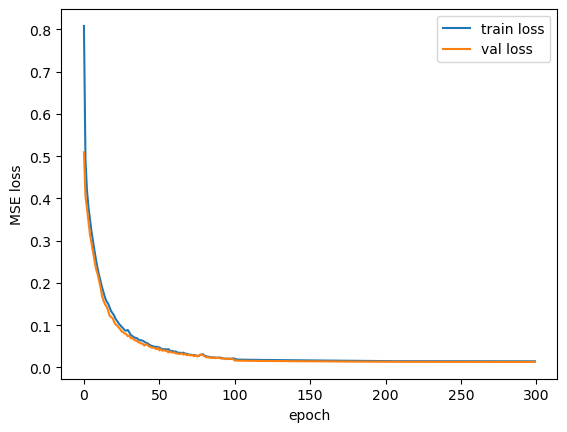

In [ ]:
# 定义模型、算法、损失函数
model = SAGEandLSTMModel(
    input_size=input_size,
    output_size=output_size,
).to(device)
# 考虑是否加入weight_decay
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-5)
# 学习率衰减
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.3)
# criterion = nn.MSELoss(reduction="sum")
criterion = nn.MSELoss().to(device)

model, train_loss_list, val_loss_list = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_graph_list=train_graph_list,
    val_graph_list=val_graph_list,
    num_epochs=300,
)

### 由于数据是通过滑动窗口生成的，所以没必要把所有数据都放进模型训练了，训练集的数据已经很有代表性

In [ ]:
# # 定义模型、算法、损失函数
# model = GATv2Model(
#     input_size=input_size,
#     output_size=output_size,
#     num_heads=num_heads,
# ).to(device)
# # 考虑是否加入weight_decay
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.MSELoss()

# model = train(model, criterion, optimizer, graphs, num_epochs=300)

In [138]:
# 保存模型
model_path = "saved/models/sage+lstm-2023.11.22.pth"
# 由于模型比较复杂，所以使用torch.save保存整个模型
torch.save(model, model_path)

# 预测

In [ ]:
# # 读取模型
# model = GATv2Model(
#     input_size=input_size,
#     output_size=output_size,
#     num_heads=num_heads,
# ).to(device)
# model.load_state_dict(torch.load(model_path))

In [120]:
# 读取node_ids
with open("data/node_ids.pkl", "rb") as file:
    node_ids = pickle.load(file)
    file.close()

In [121]:
# 读取scaler
import pickle

with open("saved/scaler/label_scaler.pkl", "rb") as file:
    label_scaler = pickle.load(file)
    file.close()

In [122]:
# 读取测试集
with open("data/test_graphs_data.pkl", "rb") as file:
    test_graphs = pickle.load(file)
    file.close()

In [123]:
len(test_graphs), test_graphs[0]

(4, Data(x=[1140, 33], edge_index=[2, 21018], edge_attr=[21018, 2]))

### 制造模型需要的数据

In [131]:
test_graphs = [graph.to(device) for graph in test_graphs]

In [132]:
test_graph_list = genLSTMData(
    graphs[-seq_len + 1 :] + test_graphs, seq_len=seq_len, stride=1
)
len(test_graph_list)

0 7
1 8
2 9
3 10


4

预测

In [133]:
model.eval()
output_list = []
with torch.no_grad():
    for i, graphs in enumerate(test_graph_list):
        output = model(graphs)
        output_list.append(output.detach().cpu().numpy())

In [134]:
len(output_list), output_list[0].shape, output_list[0][0]

(4, (1140, 2), array([-0.4999303, -1.0791613], dtype=float32))

In [135]:
# 缩放
output_list = [label_scaler.inverse_transform(output) for output in output_list]

In [136]:
# 看看是不是缩放完成啦
output_list[0][0]

array([68.53066 , 60.436707], dtype=float32)

### 把输出转成需要的格式

In [137]:
import csv

# 结果写入csv，分隔符为\t
output_path = "output/sgae+lstm.csv"

date_id = [20230404, 20230405, 20230406, 20230407]
with open(output_path, "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")  # 设置分隔符为制表符
    writer.writerow(["geohash_id", "consumption_level", "activity_level", "date_id"])

    # output_list.shape = [4天, 节点数, 2个输出]
    for nidx in range(len(node_ids)):
        for day in range(len(date_id)):
            # 注意不要写反了
            writer.writerow(
                [
                    node_ids[nidx],
                    output_list[day][nidx][1],
                    output_list[day][nidx][0],
                    date_id[day],
                ]
            )
    f.close()